In [1]:
using Plots
using ModelingToolkit

## Table of contents:

### [0] Introduction to RetinalChaos.jl

### **[1] Methods**
#### _**[1.1] Voltage and Potassium gating components of the model**_
#### [1.2] Calcium and the Biochemical Reactions of the sAHP
#### [1.3] Acetylcholine Diffusion and Dynamics
#### [1.4] Gaussian White noise and dynamics

### [2] Analyzing Data Output of the model
#### [2.1] Dynamical Analysis
#### [2.2] Fitting Experimental Data (Patch)
#### [2.3] Fitting Experimental Data (Multi-electrode array)
#### [2.4] Fitting Experimental Data (Calcium Imageing) 

### [3] Experiments
#### [3.1] Dual Eye Correlations
#### [3.2] Recapitulations of older papers

# [1] Introduction, Motivation and Components

##### Question: Why is modelling necessary

Since the introduction of electrical equivalence with Hodgkin and Huxley in 1952 many systems have
been proposed in order to model different aspects of neural activity. [1] These theoretical systems
shared a cooperative relationship with experimental data. Through the development of theoretical
models, different aspects of neural function could be predicted and better experimental techniques
utilized. With new experimental techniques, the detail and underpinnings of the theoretical models
could be improved. Further integration with various computational optimizations will continue to
improve this dynamic and allow more avenues for studying neural function and coding.
An interesting phenomena that shares this dynamic is retinal waves. Retinal waves occupy a
unique space between theoretical modelling and experimental design. One of the earliest papers
published on retinal waves was in 1976 by David Willshaw and was entirely theoretical [2]. This
paper attempted to establish a basis for the formation of topographically ordered maps by the
propagation of patterned neural activity. In 1988 these retinal waves were finally observed in a
living animal by Galli and Maffei [3].
Since then, incremental steps between theory and experiment have given much insight into the
form and function of retinal waves. It has been discovered that retinal waves occur in many different
vertebrate mammals. They exist in the retina at a time during development where the electrophysiology, molecular environment and synaptic connectivity are all rapidly changing. They have been
shown to play a pivotal role in the formation of topographic maps in the thalamus and visual cortex.
Demonstrations of these waves by using various electrophysiological methods have shown that the
frequency in which waves pass over the retina is important for remodelling of the visual cortex [4].
These waves have been found to play an instructive role in the structuring of the visual cortex [5].
The ”instructiveness” of these waves depends upon the frequency at which they propagate.


The fast dynamics of this system were initially described in the Morris Lecar Model of 1981. This describes "spikelets" which are sharp bursts of Calcium depolarizations, followed by fast potassium repolarizations. This gives the appearance of "spikelets" making up the larger "bursts". Experimentally these represent the presence of oscillatory behavior. Later analysis of these equations will demonstrate the sensitivity of this system to changes in the parameters. However first we will talk about the fast time scale changes to the system, Vt and Nt. 

### [1.1] Voltage ($V_t$) and Fast Potassium gating ($N_t$)


\begin{align}
C_m\frac{dV}{dt} = I_{leak} + I_{Ca} + I_K + +I_{TREK} + I_{app} + \sigma Wt
\end{align}

To describe the voltage, this equation uses ohmic relationships to describe conductive ion channels. In the cell membrane, the ionic current is described as the following equation. This is included in the package as the fI function 
\begin{align}
I_n = g_n * R_{\infty} * (V_t - E_n)
\end{align}
- $I_n$ is the current related to the an ion or due to some other effect $n$. 
- $g_n$ is the conductance of the specific channel. This is related to the density of the ion channels on the cell membrane
- $R_{\infty}$ is a gating variable. This varies from current to current. 
- $V_t$ is the voltage at a specific time point
- $E_n$ (or sometimes $V_n$) is the reversal potential, or the voltage at which ion influx is equal to ion efflux. 

In [2]:
import RetinalChaos.fI
#For these experiments we will conduct a mini "Voltage clamp ramp" at a range of -90.0mV to 10.0mV
v_range = collect(-90.0:0.5:10.0);

##### In the case of this model there are 5 currents. 
#### [1.1.a] Leaky Current
- 1) $I_{leak}$ or Leaky Currents: This current represents a constituently active ionic channel. This channel is important for setting the baseline. Because this channel is always open, $R_{\infty} = 1.0$ 
Leaky currents will repolarize the membrane if the membrane potential is over -70 and will depolarize the membrane if the membrane potential is under -70
\begin{align}
I_{leak} = -g_{leak} *(V_t - E_{leak})
\end{align}

In [3]:
g_leak = 2.0
E_leak = -70.0
R = 1.0 #Since the Leaky channels are always open, we will use a constant value of 1.0

1.0

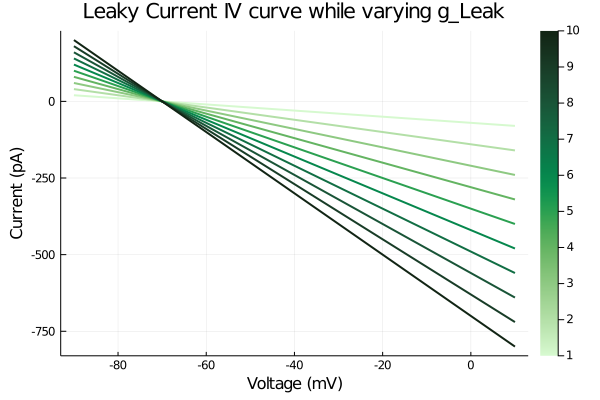

┌ Warning: Multiple series with different color share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\mtarc\.julia\packages\Plots\zOV0T\src\backends\gr.jl:491


In [4]:
#Adjusting the conductivity has an effect on the rate of change
p = plot()
my_cgrad = cgrad([:green, :cyan])
g_range = collect(1.0:10.0)
for g in g_range
    I_LEAK = map(v -> fI(g, 1.0, v, E_leak), v_range)
    plot!(p, v_range, I_LEAK, legend = :none, linewidth = 2.0, lc = :algae, line_z = g, clim = (1.0,10.0))
end
title!(p, "Leaky Current IV curve while varying g_Leak")
ylabel!(p, "Current (pA)")
xlabel!(p, "Voltage (mV)")
p

### The conductance in the current equations can be represented by the slope of the line

#### [1.1.b] Calcium Current
- 2) $I_{Ca}$ or Calcium Currents. These channels are gated by voltage specific effects which are described by the sigmoidal activation equation $M_{\infty}$. The reversal for Calcium is positive and if enough channels are activated Calcium currents will be excitatory. This means that Calcium acts as a positive feedback mechanism, activating the cell at after it has reached a threshold voltage.

The activation equation is described as:
\begin{align*}
M_\infty(V) &= \frac{1}{2} * tanh\left(\frac{V - V_1}{V_2}\right)
\end{align*}
- $V_1$ is the voltage at which 50% of the channels are open, 
- $V_2$ is the steepness of the function

### The function M_INF is described in this package in RetinalChaos/src/models.jl

In [5]:
import RetinalChaos: M_INF
# For the activation function we see
v1 = -20.0
v2 = 20.0

20.0

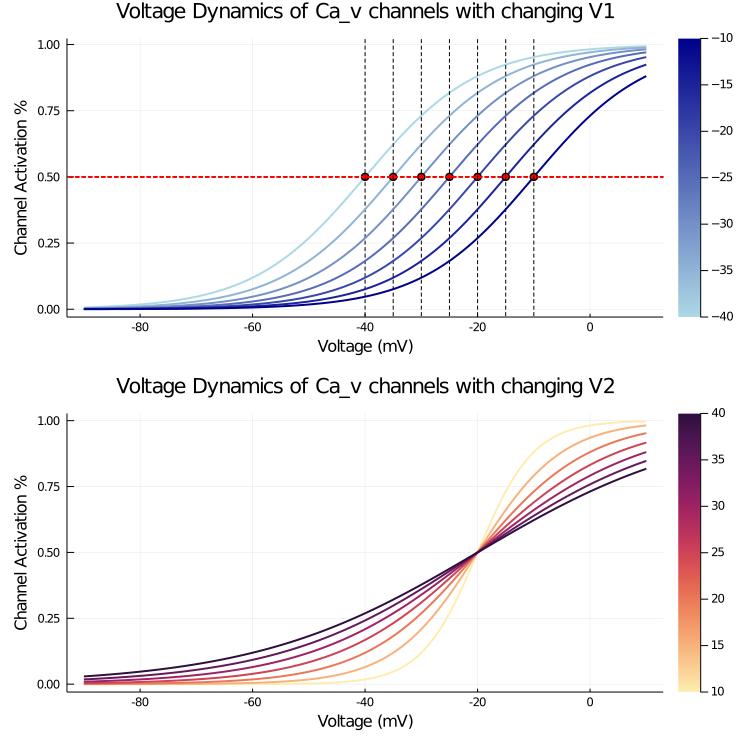

┌ Warning: Multiple series with different color share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\mtarc\.julia\packages\Plots\zOV0T\src\backends\gr.jl:491
┌ Warning: Multiple series with different color share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\mtarc\.julia\packages\Plots\zOV0T\src\backends\gr.jl:491


In [6]:
#Adjusting V1 and V2 change the dynamics of the calcium channels. The faster each channel is at activation, V2 will change. (V1 won't change)
p = plot(layout = grid(2, 1), size = (750, 750))
for y = -40.0:5.0:-10.0
    minf = map(v -> M_INF(v, y, v2), v_range)
    plot!(p[1], v_range, minf, c = :blues, line_z = y, clim = (-40.0, -10.0), linewidth = 2.0, legend = :none)
    plot!(p[1], [y], [M_INF(v1, v1, v2)], seriestype = :scatter, c = :red)
    hline!(p[1], [0.5], c = :red, linestyle = :dash)
    vline!(p[1], [y], c = :black, linestyle = :dash)
end
title!(p[1], "Voltage Dynamics of Ca_v channels with changing V1")
xlabel!(p[1], "Voltage (mV)")
ylabel!(p[1], "Channel Activation %")
for y = 10.0:5.0:40.0
    minf = map(v -> M_INF(v, v1, y), v_range)
    plot!(p[2], v_range, minf, c = :matter, line_z = y, clim = (10.0, 40.0), linewidth = 2.0, legend = :none)
end
title!(p[2], "Voltage Dynamics of Ca_v channels with changing V2")
xlabel!(p[2], "Voltage (mV)")
ylabel!(p[2], "Channel Activation %")
p

Adding this to the Current equation results in: 
\begin{align}
I_{Ca} = -g_{Ca} * M_{\infty} * (V_t - E_{Ca})
\end{align}

In [7]:
#And for the Calcium currents we have this equation
gCa = 10.0
eCa = 40.0

40.0

In [8]:
#Adjusting the conductivity has an effect on the rate of change
p = plot(layout = grid(3, 1), size = (750, 1000))
g_range = collect(1.0:10.0)
for y in g_range
    ICA = map(x -> fI(x, v, M_INF(v, v1, v2), eCa), v_range)
    plot!(p[1], v_range, ICA, legend = :none, linewidth = 2.0, lc = :thermal, line_z = y, clim = (1.0,10.0))
end
title!(p[1], "Calcium Current IV curve while varying g_Ca")
ylabel!(p[1], "Current (pA)")
xlabel!(p[1], "Voltage (mV)")

for y = -40.0:5.0:-10.0
    ICA = map(x -> fI(gCa, M_INF(x, y, v2), v, eCa), v_range)
    plot!(p[2], v_range, ICA, c = :blues, line_z = y, clim = (-40, -10.0), linewidth = 2.0, legend = :none)
end
title!(p[2], "Calcium Current IV curve with varying V1")
xlabel!(p[2], "Voltage (mV)")
ylabel!(p[2], "Current(pA)")

for y = 10.0:5.0:40.0
    ICA = map(x -> fI(gCa, M_INF(x, v1, y), v, eCa), v_range)
    plot!(p[3], v_range, ICA, c = :matter, line_z = y, clim = (10.0, 40.0), linewidth = 2.0, legend = :none)
end
title!(p[3], "Calcium Current IV curve with varying V2")
xlabel!(p[3], "Voltage (mV)")
ylabel!(p[3], "Current(pA)")
p

UndefVarError: UndefVarError: v not defined

#### [1.1.c] Potassium Current

- 3) Next we see the potassium currents. This current is dependent another independently evolving variable, $N_t$ which is described below

This equation utilizes an activation function ($N_{\infty}$) and a evolving time constant ($\Lambda$). These are outlined below
\begin{align*}
N_\infty(V) &= \frac{1 + tanh\left(\frac{V - V_3}{V_4}\right)}{2}\\
\Lambda(V) &= cosh\left(\frac{V - V_3}{2V_4}\right)\\
\end{align*}
- $V_3$ is the voltage at which 50% of the channels are open, 
- $V_4$ is the steepness of the function

In [9]:
#Importing N_INF and Λ into the equations
import RetinalChaos: N_INF, Λ

In [10]:
# For the activation function we see
V3 = -25.0
V4 = 7.0

7.0

┌ Warning: Multiple series with different color share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\mtarc\.julia\packages\Plots\zOV0T\src\backends\gr.jl:491


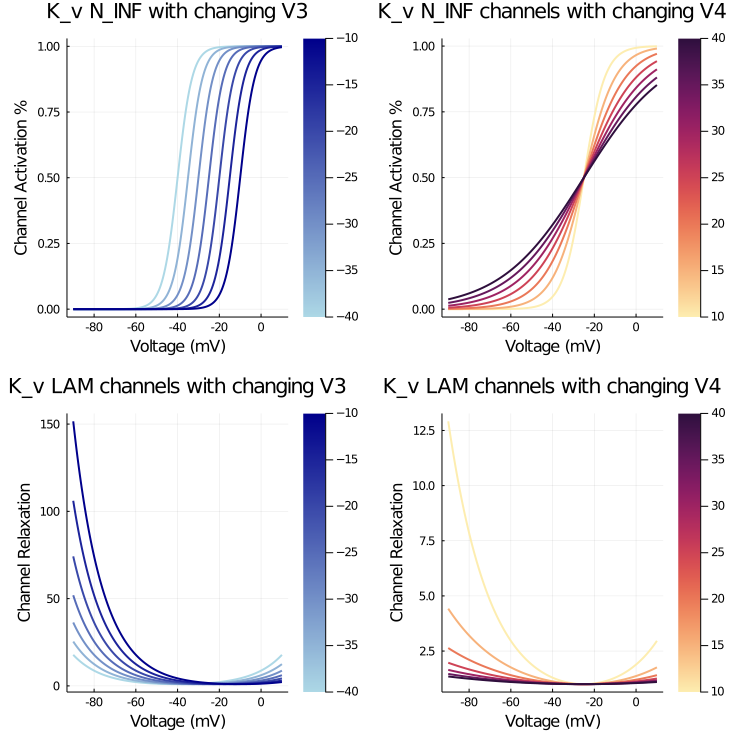

┌ Warning: Multiple series with different color share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\mtarc\.julia\packages\Plots\zOV0T\src\backends\gr.jl:491
┌ Warning: Multiple series with different color share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\mtarc\.julia\packages\Plots\zOV0T\src\backends\gr.jl:491
┌ Warning: Multiple series with different color share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\mtarc\.julia\packages\Plots\zOV0T\src\backends\gr.jl:491


In [11]:
#Adjusting V1 and V2 change the dynamics of the Potassium channels.
p = plot(layout = grid(2, 2), size = (750, 750))
for v3 = -40.0:5.0:-10.0
    minf = map(v -> N_INF(v, v3, V4), v_range)
    plot!(p[1], v_range, minf, c = :blues, line_z = v3, clim = (-40.0, -10.0), linewidth = 2.0, legend = :none)
end
title!(p[1], "K_v N_INF with changing V3")
xlabel!(p[1], "Voltage (mV)")
ylabel!(p[1], "Channel Activation %")


for v4 = 10.0:5.0:40.0
    minf = map(v -> N_INF(v, V3, v4), v_range)
    plot!(p[2], v_range, minf, c = :matter, line_z = v4, clim = (10.0, 40.0), linewidth = 2.0, legend = :none)
end
title!(p[2], "K_v N_INF channels with changing V4")
xlabel!(p[2], "Voltage (mV)")
ylabel!(p[2], "Channel Activation %")


for v3 = -40.0:5.0:-10.0
    minf = map(v -> Λ(v, v3, V4), v_range)
    plot!(p[3], v_range, minf, c = :blues, line_z = v3, clim = (-40.0, -10.0), linewidth = 2.0, legend = :none)
end
title!(p[3], "K_v LAM channels with changing V3")
xlabel!(p[3], "Voltage (mV)")
ylabel!(p[3], "Channel Relaxation")


for v4 = 10.0:5.0:40.0
    minf = map(v -> Λ(v, V3, v4), v_range)
    plot!(p[4], v_range, minf, c = :matter, line_z = v4, clim = (10.0, 40.0), linewidth = 2.0, legend = :none)
end
title!(p[4], "K_v LAM channels with changing V4")
xlabel!(p[4], "Voltage (mV)")
ylabel!(p[4], "Channel Relaxation")

p

$N_t$ is described in the differential equation
\begin{align}
\tau_N\frac{dN}{dt} &= \Lambda(V)(N_\infty(V) - N)\\
\end{align}

In the $N_t$ equation, $\tau_N$ is the time constant. A normal parameter for this time constant is 5ms. Which means that every 5ms all of the previously active potassium channels have "relaxed"

In order to show this, We will utilize a voltage step in a differential equation (similar to how I described a new model in 0.0)

Below I will demonstrate:
- The effect of changing the voltage step (v_app)
- The Effect of changing V3, V4
- The effect of changing $\tau_n$

I will include a variable in the equation for:
- The Calcium current 
$$I_{Ca} = -g_{Ca} * M_{\infty} * (V_t - E_{Ca})$$
and the Potassium Currents
$$I_{Ca} = -g_K * N_t * (V_t - E_K)$$

In [12]:
import DifferentialEquations: ContinuousCallback, CallbackSet, solve, EnsembleProblem, EnsembleThreads
import RetinalChaos: extract_dict, ensemble_func

In [18]:
#Callback for voltage step
tspan = (0.0, 50.0)
t_start = 10.0; t_end = 30.0
cb1 = ContinuousCallback((u, t, integrator) -> (t < t_start), integrator -> integrator.u[1] = integrator.p[end]);
cb2 = ContinuousCallback((u, t, integrator) -> (t < t_end),  integrator -> integrator.u[1] = -70.0);
cb = CallbackSet(cb1, cb2);

In [21]:
@parameters t V1 V2 V3 V4 τn v_app g_K g_Ca E_K E_Ca
@variables v(t) n(t) I_Ca(t) I_K(t)
@derivatives d'~t

eqs = [
    d(v) ~ 0.0*v_app
    d(n) ~ (Λ(v, V3, V4) * (N_INF(v, V3, V4) - n))/τn
    ]
n_ode = ODESystem(eqs)

u0 = [v => -70.0, n => 0.0]
p = Dict(:V3 => -25.0, :V4 => 7.0, :τn => 5.0, :v_app => -60.0) |> extract_dict
prob = ODEProblem(n_ode, u0, tspan, p)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 50.0)
u0: [-70.0, 0.0]

In [22]:
n_ode.ps

4-element Array{Variable,1}:
 V4   
 V3   
 τn   
 v_app

  0.015758 seconds (33.10 k allocations: 1.031 MiB)


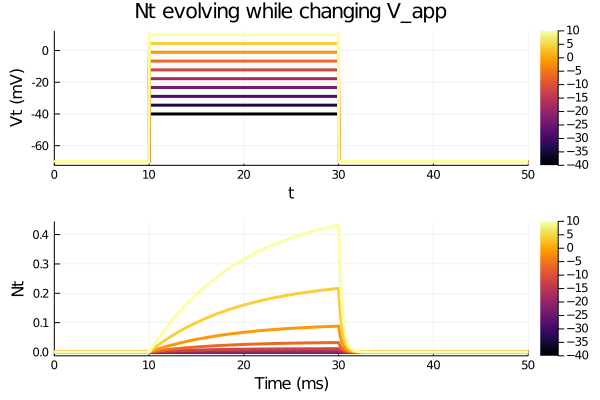

┌ Warning: Multiple series with different color share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\mtarc\.julia\packages\Plots\zOV0T\src\backends\gr.jl:491
┌ Warning: Multiple series with different color share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\mtarc\.julia\packages\Plots\zOV0T\src\backends\gr.jl:491


In [35]:
n_sims = 10
rng = LinRange(-40, 10.0, n_sims)
prob_func(prob, i, repeat) = ensemble_func(prob, i, repeat; pars = 4, rng = rng)
ensemble_prob = EnsembleProblem(prob, prob_func = prob_func)
@time sim = solve(ensemble_prob, callback = cb, tstops = [t_start, t_end], trajectories = n_sims, EnsembleThreads());

p = plot(layout = grid(2,1))
for i = 1:n_sims
    plot!(p, sim[i], clims = (rng[1], rng[end]), line_z = rng[i], lw = 3.0, legend = :none)
end
xlabel!(p[2], "Time (ms)")
ylabel!(p[1], "Vt (mV)")
ylabel!(p[2], "Nt")
title!(p[1], "Nt evolving while changing V_app")
p

  0.015934 seconds (21.22 k allocations: 741.604 KiB)


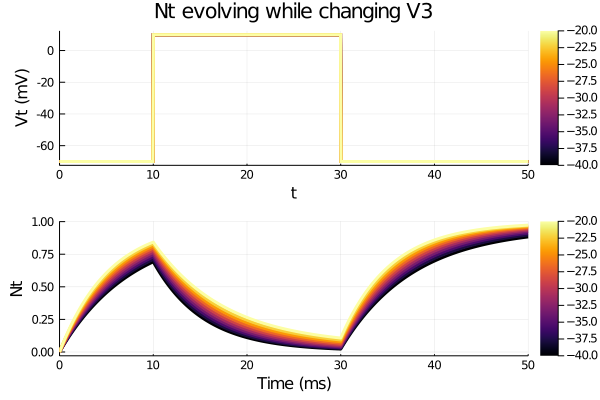

┌ Warning: Multiple series with different color share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\mtarc\.julia\packages\Plots\zOV0T\src\backends\gr.jl:491
┌ Warning: Multiple series with different color share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\mtarc\.julia\packages\Plots\zOV0T\src\backends\gr.jl:491


In [37]:
n_sims = 10
rng = LinRange(-40, -20.0, n_sims)
prob_func(prob, i, repeat) = ensemble_func(prob, i, repeat; pars = 2, rng = rng)
ensemble_prob = EnsembleProblem(prob, prob_func = prob_func)
@time sim = solve(ensemble_prob, callback = cb, tstops = [t_start, t_end], trajectories = n_sims, EnsembleThreads());

p = plot(layout = grid(2,1))
for i = 1:n_sims
    plot!(p, sim[i], clims = (rng[1], rng[end]), line_z = rng[i], lw = 3.0, legend = :none)
end
xlabel!(p[2], "Time (ms)")
ylabel!(p[1], "Vt (mV)")
ylabel!(p[2], "Nt")
title!(p[1], "Nt evolving while changing V3")
p

  0.020905 seconds (31.88 k allocations: 1.003 MiB)


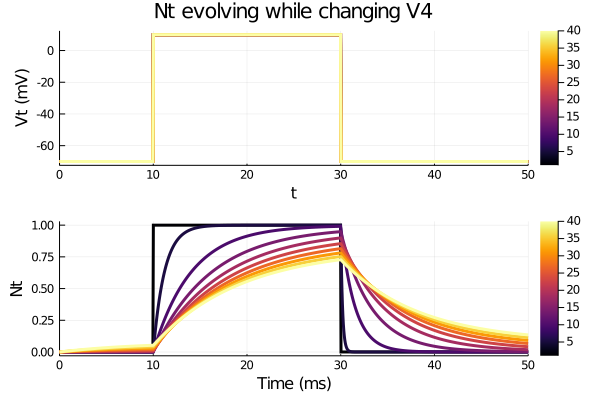

┌ Warning: Multiple series with different color share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\mtarc\.julia\packages\Plots\zOV0T\src\backends\gr.jl:491
┌ Warning: Multiple series with different color share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\mtarc\.julia\packages\Plots\zOV0T\src\backends\gr.jl:491


In [39]:
n_sims = 10
rng = LinRange(1.0, 40.0, n_sims)
prob_func(prob, i, repeat) = ensemble_func(prob, i, repeat; pars = 1, rng = rng)
ensemble_prob = EnsembleProblem(prob, prob_func = prob_func)
@time sim = solve(ensemble_prob, callback = cb, tstops = [t_start, t_end], trajectories = n_sims, EnsembleThreads());

p = plot(layout = grid(2,1))
for i = 1:n_sims
    plot!(p, sim[i], clims = (rng[1], rng[end]), line_z = rng[i], lw = 3.0, legend = :none)
end
xlabel!(p[2], "Time (ms)")
ylabel!(p[1], "Vt (mV)")
ylabel!(p[2], "Nt")
title!(p[1], "Nt evolving while changing V4")
p

In [34]:
n_sims = 10
rng = LinRange(-40, 10.0, n_sims)
prob_func(prob, i, repeat) = ensemble_func(prob, i, repeat; pars = 3, rng = rng)
ensemble_prob = EnsembleProblem(prob, prob_func = prob_func)
@time sim = solve(ensemble_prob, callback = cb, tstops = [t_start, t_end], trajectories = n_sims, EnsembleThreads());

p = plot(layout = grid(2,1))
for i = 1:n_sims
    plot!(p, sim[i], clims = (rng[1], rng[end]), line_z = rng[i], lw = 3.0, legend = :none)
end
xlabel!(p[2], "Time (ms)")
ylabel!(p[1], "Vt (mV)")
ylabel!(p[2], "Nt")
title!(p[1], "Nt evolving while changing Tau_N")
p

  0.025748 seconds (78.18 k allocations: 2.236 MiB)


┌ Warning: Instability detected. Aborting
└ @ DiffEqBase C:\Users\mtarc\.julia\packages\DiffEqBase\A6T7i\src\integrator_interface.jl:349


InexactError: InexactError: trunc(Int64, -Inf)

#### In later equilibrium diagrams, the N variable will be used to discern oscillatory behavior. In this diagram we can see some of the initial oscillatory behavior begin to evolve. 

In [ ]:
p = plot(layout = grid(1,3), size = (1300, 400))


for v3 = -40.0:5.0:-10.0
    DELTA_N = map(v -> nt(v, v3, V4, n0, tN), v_range)
    plot!(p[1], v_range, DELTA_N, c = :delta, line_z = v3, clim = (-40.0, -10.0), linewidth = 2.0, legend = :none)
end
title!(p, "Instantaneous dN while varying V3")
xlabel!(p[1], "Voltage (mV)")
ylabel!(p[1], "Instantaneous dN/dt")


for v4 = 10.0:5.0:40.0
    DELTA_N = map(v -> nt(v, V3, v4, n0, tN), v_range)
    plot!(p[2], v_range, DELTA_N, c = :curl, line_z = v4, clim = (10.0, 40.0), linewidth = 2.0, legend = :none)
end
title!(p[2], "Instantaneos dN while varying V4")
xlabel!(p[2], "Voltage (mV)")
#ylabel!(p[2], "Instantaneous dN/dt")

for tn = 0.0:0.5:5.0
    DELTA_N = map(v -> nt(v, V3, V4, n0, tn), v_range)
    plot!(p[3], v_range, DELTA_N, c = :balance, line_z = tn, clim = (0.0, 5.0), linewidth = 2.0, legend = :none)
end
title!(p[3], "Instantaneos dN while varying tau_N")
xlabel!(p[3], "Voltage (mV)")
#ylabel!(p[3], "Instantaneous dN/dt")

#### K currents derived from these interactions won't make much sense unless you think about them in the context of the Differential Equation. 
#### However we can describe them as "Instantaneous currents" or how the current will change at that single sn. Later, once these variables are placed within the ODE framework they will be much more descriptive 

In [ ]:
p = plot(layout = grid(1,3), size = (1300, 400))


for v3 = -40.0:5.0:-10.0
    ik = map(v -> I_K(g_K, v, E_K, nt(v, v3, V4, n0, tN)), v_range)
    plot!(p[1], v_range, ik, c = :delta, line_z = v3, clim = (-40,-10), linewidth = 2.0, legend = :none)
end
title!(p, "Instantaneous I_K while varying V3")
xlabel!(p[1], "Voltage (mV)")
ylabel!(p[1], "Inst I_K (pA)")


for v4 = 10.0:5.0:40.0
    ik = map(v -> I_K(g_K, v, E_K, nt(v, V3, v4, n0, tN)), v_range)
    plot!(p[2], v_range, ik, c = :curl, line_z = v4, clim = (10,40), linewidth = 2.0, legend = :none)
end
title!(p[2], "Instantaneos I_K while varying V4")
xlabel!(p[2], "Voltage (mV)")
#ylabel!(p[1], "Inst I_K (pA)")

for tn = 0.0:0.5:5.0
    ik = map(v -> I_K(g_K, v, E_K, nt(v, V3, V4, n0, tn)), v_range)
    plot!(p[3], v_range, ik, c = :balance, line_z = tn, clim = (0.0, 5.0), linewidth = 2.0, legend = :none)
end
title!(p[3], "Instantaneos I_K while varying tau_N")
xlabel!(p[3], "Voltage (mV)")
#ylabel!(p[1], "Inst I_K (pA)")

#### These currents are included in the original Morris-Lecar Model published in 1981

\begin{align}
C_m\frac{dV}{dt} &= (-g_{leak} *(V_t - E_{leak})) + (-g_{Ca} * M_{\infty} * (V_t - E_{Ca})) + (-g_K * N_t * (V_t - E_K)) + I_{app}\\
\tau_N\frac{dN}{dt} &= \Lambda(V)(N_\infty(V) - N)
\end{align}

In [ ]:
ML = @ode_def begin
    dv = ((-g_leak * (v - E_leak)) + (-g_Ca * M_INF(v, V1, V2) * (v - E_Ca)) + (-g_K * n * (v - E_K)) + I_app)/C_m
    dn = (LAM(v, V3, V4) * ((N_INF(v, V3, V4) - n)))/tau_N
end g_leak E_leak g_Ca V1 V2 E_Ca g_K E_K I_app C_m V3 V4 tau_N

In [ ]:
I_app = 10.0;
C_m = 22.0;
u0 = [-70.0, 0.0];
pars = [g_leak, E_leak, g_Ca, V1, V2, E_Ca, g_K, E_K, I_app, C_m, V3, V4, tN];
tspan = (0.0, 200.0);
prob = ODEProblem(ML, u0, tspan, pars);
println("Time it took to simulate 200ms:")
@time sol = solve(prob, saveat = 0.01);
#We can extract voltage and N traces from the model
time = sol.t
dt = time[2] #The change in time can easily be determined by taking the second point, however we set it to 0.01
println("dt = $dt") #This we can check to ensure 
v_trace = map(x -> x[1], sol.u);
n_trace = map(x -> x[2], sol.u);

In [ ]:
p = plot(layout = grid(2, 1))
title!(p[1], "Representative traces with 10pA of current injection")
plot!(p[1], time, v_trace, linewidth = 2.0, c = :magenta, legend = :none)
ylabel!(p[1], "Voltage (mV)")
plot!(p[2], time, n_trace, linewidth = 2.0, c = :green, legend = :none)
ylabel!(p[2], "K Gating")
xlabel!(p[2], "Time (ms)")

In [ ]:
plot(v_trace, n_trace, legend = :none, linewidth = 2.0, c = :red)
title!("Nt vs Vt trajectory diagram")
ylabel!("K Gating (%)")
xlabel!("Voltage (mV)")

In [ ]:
#Breakdown of the currents driving this model
Il_trace = map(v -> I_leak(g_leak, v, E_leak), v_trace);
Ic_trace = map(v -> I_Ca(g_Ca, v, E_Ca, V1, V2), v_trace);
Ik_trace = map(u -> I_K(g_K, u[1], E_K, u[2]), sol.u)
#plot(time, v_trace, label = "Voltage")
plot(time, Il_trace, label = "Leaky Current", linewidth = 2.0, c = :black)
plot!(time, Ic_trace, label = "Calcium Current", linewidth = 2.0, c = :green)
plot!(time, Ik_trace, label = "Potassium Current", linewidth = 2.0, c = :red)
ylabel!("Currents (pA)")
xlabel!("Time (ms)")

#### Two interesting variables that can convert directly to experimental variables are the applied current $I_{app}$ and the membrane capacitance $C_m$. 

##### [1.1.d] First we can talk about the membrane capacitance($C_m$). The speed at which the membrane can charge and discharge is related to the membrane capacitance. The higher the $C_m$ the more slowly the cell will charge and discharge.  

In [ ]:
tspan = (0.0, 100.0);
u0 = [-70.0, 0.0];
p = plot(layout = grid(2, 1), size = (1000, 1000))
for i = 5.0:5.0:20.0
    I_app = 10.0;
    C_m = i;
    pars = [g_leak, E_leak, g_Ca, V1, V2, E_Ca, g_K, E_K, I_app, C_m, V3, V4, tN];
    prob = ODEProblem(ML, u0, tspan, pars);
    sol = solve(prob, saveat = 0.01);
    n_points = length(sol.t)
    cm_space = repeat([i], n_points)
    v_trace = map(x -> x[1], sol.u);
    n_trace = map(x -> x[2], sol.u);
    plot!(p[1], sol.t, v_trace, c = :viridis, line_z = i, clims = (5, 20), legend = :none, linewidth = 2.0)
    plot!(p[2], n_trace, v_trace,  c = :viridis, line_z = i, clims = (5, 20), legend = :none, linewidth = 2.0)
end
title!(p[1], "Dynamics of ODE while adjusting C_m (I_app = 10.0pA)")
xlabel!(p[1], "Time (ms)")
xlabel!(p[2], "Nt (%)")
p

##### [1.1.d] Next we can talk about the applied or injected current ($I_{app}$).  

In [ ]:
tspan = (0.0, 100.0);
u0 = [-70.0, 0.0];
p = plot(layout = grid(2, 1), size = (1000, 1000))
for i = -50.0:20.0:200
    I_app = i;
    C_m = 22.0;
    pars = [g_leak, E_leak, g_Ca, V1, V2, E_Ca, g_K, E_K, I_app, C_m, V3, V4, tN];
    prob = ODEProblem(ML, u0, tspan, pars);
    sol = solve(prob, saveat = 0.01);
    n_points = length(sol.t)
    cm_space = repeat([i], n_points)
    v_trace = map(x -> x[1], sol.u);
    n_trace = map(x -> x[2], sol.u);
    plot!(p[1], sol.t, v_trace, c = :viridis, line_z = i, clims = (-50, 200), legend = :none, linewidth = 2.0)
    plot!(p[2], n_trace, v_trace,  c = :viridis, line_z = i, clims = (-50, 200), legend = :none, linewidth = 2.0)
end
title!(p[1], "Dynamics of ODE while adjusting I_app (C_m = 22.0nF)")
xlabel!(p[1], "Time (ms)")
ylabel!(p[2], "Nt (%)")
xlabel!(p[2], "Injected Current (pA)")
p

#### Later when we talk about equilibria, the Injected current ($I_{app}$) will have a larger role to play. 

### Discussion

The original Morris Lecar model is composed of the same elements here. The dynamics of the Leaky, K, and Ca voltage gated channels is explained. The evolution of Vt and Nt is related to these variables and alot can be done with just these components experimentally and theoretically. Much emphasis is placed on the $Ca_v$ and $K_v$ conductances later in the model ($g_{Ca}$ and $g_K$ respectively). The interplay between these two conductances greatly influences the presence of oscillatory behavior, which is later determined to be related to "bursting" behaviour typical of Starburst Amacrine Cells (SACs) in the retina. 

## In the next notebook
We will discuss the slow afterhyperpolarization and how it is comprised. 